# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

This is the starting logic (before extra cases complicate it):

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [87]:
import pandas as pd
import os
import matplotlib.pylab as plt
# import logging
# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger('foo').debug('bah')
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger('foo').debug('bah')

In [88]:
df = pd.read_csv('signals.csv',index_col=None, header=None)
df.columns = ['ticker', 'price', 'time', 'meta_signal', 'meta_previous', 
              '4h', '1d','1w', '1m', 
              '4hp', '1dp', '1wp', '1mp', 
              '4h_rsi', '4h_stochrsi','4h_stoch', '4h_ult', '4h_macd', '4h_hull', 
              '1d_rsi', '1d_stochrsi','1d_stoch', '1d_ult', '1d_macd', '1d_hull', 
              '1w_rsi', '1w_stochrsi','1w_stoch', '1w_ult', '1w_macd', '1w_hull', 
              '1m_rsi', '1m_stochrsi','1m_stoch', '1m_ult', '1m_macd', '1m_hull', 
              'meta_move', 
              'Meta OK','Meta Good', 'Meta ⬆️', 'Meta ⬆️⬆️', 'Meta Bad', 'Meta ⬇️', 'Meta ⬇️⬇️',
              'RSI Over Short', 'RSI Over Long', 'RSI Over All', 'RSI Under Short','RSI Under Long', 'RSI Under All', 
              'StochRSI Over Short','StochRSI Over Long', 'StochRSI Over All', 'StochRSI Under Short','StochRSI Under Long', 'StochRSI Under All', 
              'Stoch Over Short','Stoch Over Long', 'Stoch Over All', 'Stoch Under Short','Stoch Under Long', 'Stoch Under All', 
              'Ult Over Short','Ult Over Long', 'Ult Over All', 'Ult Under Short', 'Ult Under Long', 'Ult Under All'
    
]
df.head(5)

,ticker,price,time,meta_signal,meta_previous,4h,1d,1w,1m,4hp,...,Stoch Over All,Stoch Under Short,Stoch Under Long,Stoch Under All,Ult Over Short,Ult Over Long,Ult Over All,Ult Under Short,Ult Under Long,Ult Under All
0,AMEX-BTG,2.310,1534976694686,-1,0,-1,-1,-1,-1,0.0,...,0,0,1,0,0,0,0,0,0,0
1,AMEX-BTG,2.240,1535032150741,-1,0,-1,-1,-1,-1,0.0,...,0,0,1,0,0,0,0,0,0,0
2,AMEX-BTG,2.235,1535036020573,-1,0,-1,-1,-1,-1,0.0,...,0,0,1,0,0,0,0,0,0,0
3,AMEX-BTG,2.210,1535039443967,-1,0,-1,-1,-1,-1,0.0,...,0,0,1,0,0,0,0,0,0,0
4,AMEX-BTG,2.215,1535042714300,-1,0,-1,-1,-1,-1,0.0,...,0,0,1,0,0,0,0,0,0,0


In [89]:
def label_actions(df_ticker, ticker, verbose=False, significance=0.10):
    df_ticker['action'] = 'hold'
    holding=0
    cost_basis=0
    liquid=0
    profit=0
    buys=0
    sells=0
    last_basis=0
    last_row_i=-1
    last_quantity_sold=0
    last_profit=0
    first_row_i=0
    elapsed_minutes_since_last_record=0
    for i, row in df_ticker.iterrows():
        if last_row_i==-1:
            # first record: buy one
            buys=1
            holding=1
            cost_basis = row.price
            df_ticker.set_value(i,'action','buy')
            first_row_i = i
        else:
            last_row = df_ticker.loc[last_row_i]
            last_sell = last_row.action=='sell'
            last_buy = last_row.action=='buy'
            price_same = row.price == last_row.price
            elapsed_minutes_since_last_record = (row.time - last_row.time) / 1000 / 60
            # TODO: also ensure price has changed at least 1%-5% or .05...or something
            # >= to catch moving the sell signal over a plateau 
            if (row.price >= cost_basis) & ((row.price > last_row.price) | (price_same & last_sell)):
                df_ticker.set_value(i,'action','sell')
                if last_row.action == "sell":
                    df_ticker.set_value(last_row_i,'action','hold')
                    # remove the recorded profit from the last sale
                    profit -= last_profit
                    # add the profit from selling at this price
                    last_profit=(last_quantity_sold * (row.price - last_basis))
                    profit += last_profit
                else:
#                     significant = (row.price - last_row.price > significance)
#                     if significant:
                        if holding == 0:
                           print('!!!!!!!!!!!!Anomaly!!', ticker) 
                        last_quantity_sold=holding
                        last_profit=(holding * (row.price - cost_basis))
                        profit += last_profit
                        sells += 1
                        last_basis=cost_basis
                        holding = 0
                        cost_basis = 0
            elif ((cost_basis==0) | (row.price <= cost_basis)) & ((row.price < last_row.price) | (price_same & last_buy)):
                df_ticker.set_value(i,'action','buy')
                if (last_row.action == "buy"):
                    
                    # update the first entry to a sell if the price went down (significantly?)
                    if (last_row_i == first_row_i) & (not price_same):
                        df_ticker.set_value(last_row_i,'action','sell')
                    else:
                        df_ticker.set_value(last_row_i,'action','hold')
                    # adjust the recorded cost-basis to the new cost
                    last_held = holding-1
                    if last_held==0:
                        cost_basis = row.price
                    else:
                        cost_basis = ((last_basis * last_held) + row.price) / (holding)
                    last_basis=cost_basis
                else:
#                     significant = (last_row.price - row.price > significance)
#                     if(significant):
                        last_basis = cost_basis
                        if holding==0:
                            cost_basis = row.price
                        else:
                            cost_basis = ((cost_basis * holding) + row.price) / (holding+1)
                        holding += 1
                        buys += 1
                    
        if verbose:
            print("time:", "{0:.2f}".format(elapsed_minutes_since_last_record), df_ticker.get_value(i,'action'), "\tprice: {0:.2f}".format(row.price), '\tholding:', holding, "\tbasis: {0:.2f}".format(cost_basis),"\tlast basis: {0:.2f}".format(last_basis), "\tprofit: {0:.4f}".format(profit))
#             print(row['4h_rsi'], row['4h_stochrsi'])
        last_row_i = i
        liquid = (row.price*holding) - (cost_basis*holding) + profit

    print(ticker+'\t', "holding:", holding, "\tbasis:", "{0:.2f}".format(cost_basis), "\trealized:", "{0:.2f}".format(profit), "\tliquid:","{0:.2f}".format(liquid), "\tbuys:", buys, "\tsells:",sells)
    return df_ticker

In [90]:
ticker_groups = df.groupby('ticker')

time: 0.00 buy 	price: 19.06 	holding: 1 	basis: 19.06 	last basis: 0.00 	profit: 0.0000
time: 828.66 buy 	price: 18.69 	holding: 1 	basis: 18.69 	last basis: 18.69 	profit: 0.0000
time: 65.37 buy 	price: 18.54 	holding: 1 	basis: 18.54 	last basis: 18.54 	profit: 0.0000
time: 56.70 buy 	price: 18.54 	holding: 1 	basis: 18.54 	last basis: 18.54 	profit: 0.0000
time: 54.15 buy 	price: 18.50 	holding: 1 	basis: 18.50 	last basis: 18.50 	profit: 0.0000
time: 53.88 buy 	price: 18.44 	holding: 1 	basis: 18.44 	last basis: 18.44 	profit: 0.0000
time: 54.29 buy 	price: 18.42 	holding: 1 	basis: 18.42 	last basis: 18.42 	profit: 0.0000
time: 53.84 buy 	price: 18.39 	holding: 1 	basis: 18.39 	last basis: 18.39 	profit: 0.0000
time: 53.17 sell 	price: 18.46 	holding: 0 	basis: 0.00 	last basis: 18.39 	profit: 0.0650
time: 1023.34 sell 	price: 18.78 	holding: 0 	basis: 0.00 	last basis: 18.39 	profit: 0.3850
time: 61.66 sell 	price: 18.98 	holding: 0 	basis: 0.00 	last basis: 18.39 	profit: 0.590

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


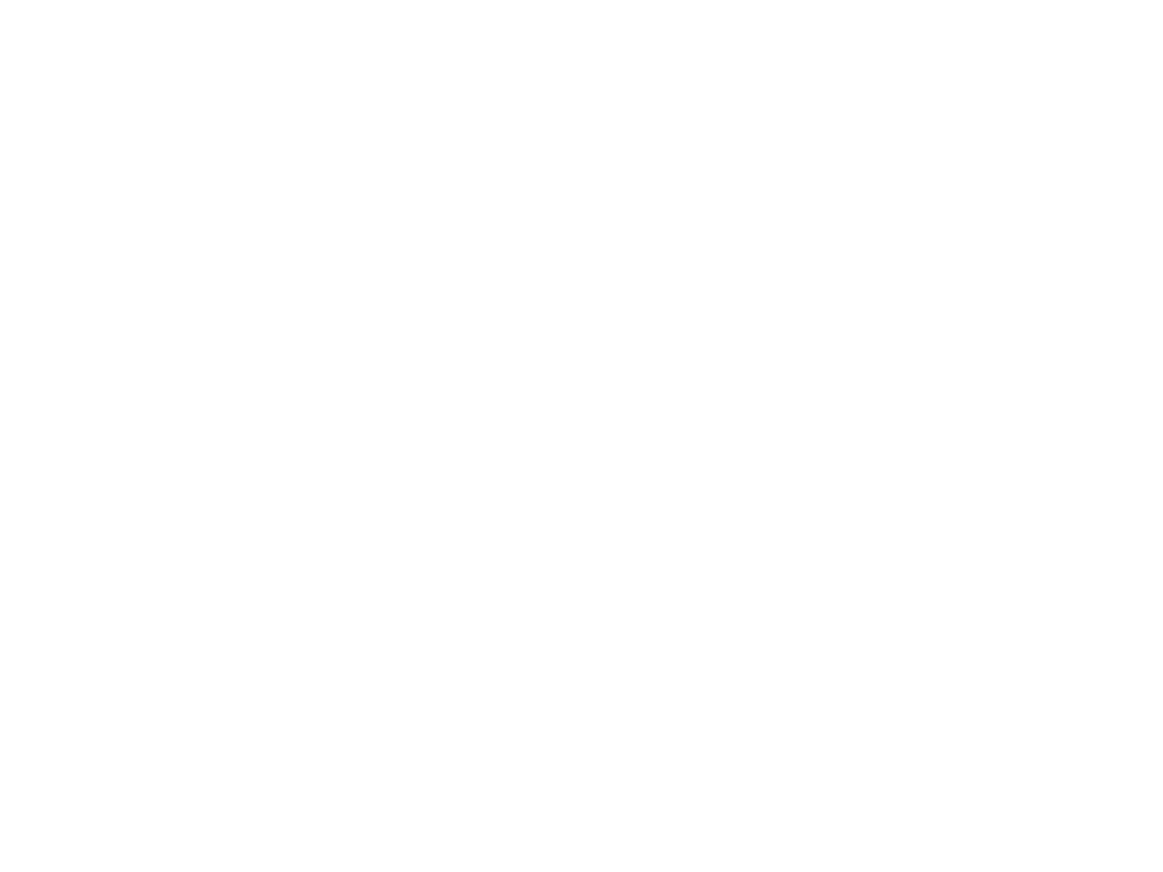

In [91]:
# testing
# test_ticker = 'AMEX-BTG'
# test_ticker = 'AMEX-FXI'
test_ticker = 'AMEX-GDX'
# test_ticker = 'NASDAQ-AAPL'
# test_ticker = 'AMEX-UAMY'
df_test_ticker = label_actions(ticker_groups.get_group(test_ticker), test_ticker, verbose=True)

%matplotlib notebook

plt.figure(1)
plt.title(test_ticker+' signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_test_ticker.price)
plt.plot(df_test_ticker[df_test_ticker.action=="sell"].price, 'ro', label='sell')
plt.plot(df_test_ticker[df_test_ticker.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()

In [92]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [93]:
df_labeled = pd.DataFrame()
list_ = []

for ticker, group in ticker_groups:
    df_ticker = label_actions(group, ticker)
    list_.append(df_ticker)

df_labeled = pd.concat(list_)
# frame.sort_values(['ticker', 'time'], inplace=True)
df_labeled.head(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AMEX-BTG	 holding: 1 	basis: 2.31 	realized: 0.33 	liquid: 0.33 	buys: 7 	sells: 6
AMEX-COPX	 holding: 1 	basis: 21.71 	realized: 1.65 	liquid: 1.65 	buys: 9 	sells: 8
AMEX-DGRO	 holding: 0 	basis: 0.00 	realized: 0.73 	liquid: 0.73 	buys: 9 	sells: 9
AMEX-EWA	 holding: 0 	basis: 0.00 	realized: 0.94 	liquid: 0.94 	buys: 6 	sells: 6
AMEX-FXI	 holding: 0 	basis: 0.00 	realized: 2.54 	liquid: 2.54 	buys: 8 	sells: 8
AMEX-GDX	 holding: 0 	basis: 0.00 	realized: 1.31 	liquid: 1.31 	buys: 4 	sells: 4
AMEX-GDXJ	 holding: 0 	basis: 0.00 	realized: 2.37 	liquid: 2.37 	buys: 6 	sells: 6
AMEX-GSAT	 holding: 1 	basis: 0.49 	realized: 0.06 	liquid: 0.06 	buys: 8 	sells: 7
AMEX-GTE	 holding: 1 	basis: 3.51 	realized: 0.44 	liquid: 0.44 	buys: 8 	sells: 7
AMEX-HDV	 holding: 0 	basis: 0.00 	realized: 1.37 	liquid: 1.37 	buys: 5 	sells: 5
AMEX-IAU	 holding: 1 	basis: 11.50 	realized: 0.33 	liquid: 0.33 	buys: 4 	sells: 3
AMEX-IDV	 holding: 0 	basis: 0.00 	realized: 0.80 	liquid: 0.80 	buys: 5 	sells: 

NYSE-ECR	 holding: 1 	basis: 1.39 	realized: 0.15 	liquid: 0.15 	buys: 5 	sells: 4
NYSE-EGO	 holding: 0 	basis: 0.00 	realized: 0.14 	liquid: 0.14 	buys: 9 	sells: 9
NYSE-ETN	 holding: 0 	basis: 0.00 	realized: 3.80 	liquid: 3.80 	buys: 7 	sells: 7
NYSE-EXG	 holding: 0 	basis: 0.00 	realized: 0.27 	liquid: 0.27 	buys: 6 	sells: 6
NYSE-EXK	 holding: 0 	basis: 0.00 	realized: 0.37 	liquid: 0.37 	buys: 7 	sells: 7
NYSE-F	 holding: 1 	basis: 9.74 	realized: 0.54 	liquid: 0.54 	buys: 7 	sells: 6
NYSE-FNF	 holding: 1 	basis: 39.98 	realized: 1.48 	liquid: 1.48 	buys: 11 	sells: 10
NYSE-FTV	 holding: 0 	basis: 0.00 	realized: 5.52 	liquid: 5.52 	buys: 9 	sells: 9
NYSE-GE	 holding: 0 	basis: 0.00 	realized: 0.88 	liquid: 0.88 	buys: 12 	sells: 12
NYSE-GG	 holding: 0 	basis: 0.00 	realized: 0.84 	liquid: 0.84 	buys: 6 	sells: 6
NYSE-GGP	 holding: 0 	basis: 0.00 	realized: 0.76 	liquid: 0.76 	buys: 7 	sells: 7
NYSE-GME	 holding: 1 	basis: 13.69 	realized: 0.96 	liquid: 0.96 	buys: 9 	sells: 8
NY

,ticker,price,time,meta_signal,meta_previous,4h,1d,1w,1m,4hp,...,Stoch Under Short,Stoch Under Long,Stoch Under All,Ult Over Short,Ult Over Long,Ult Over All,Ult Under Short,Ult Under Long,Ult Under All,action
0,AMEX-BTG,2.310,1534976694686,-1,0,-1,-1,-1,-1,0.0,...,0,1,0,0,0,0,0,0,0,sell
1,AMEX-BTG,2.240,1535032150741,-1,0,-1,-1,-1,-1,0.0,...,0,1,0,0,0,0,0,0,0,hold
2,AMEX-BTG,2.235,1535036020573,-1,0,-1,-1,-1,-1,0.0,...,0,1,0,0,0,0,0,0,0,hold
3,AMEX-BTG,2.210,1535039443967,-1,0,-1,-1,-1,-1,0.0,...,0,1,0,0,0,0,0,0,0,buy
4,AMEX-BTG,2.215,1535042714300,-1,0,-1,-1,-1,-1,0.0,...,0,1,0,0,0,0,0,0,0,hold


In [94]:
# testing
test_ticker = 'AMEX-GDX'
# test_ticker = 'AMEX-UAMY'
df_test_ticker = df_labeled[df_labeled.ticker == test_ticker]
df_test_ticker

,ticker,price,time,meta_signal,meta_previous,4h,1d,1w,1m,4hp,...,Stoch Under Short,Stoch Under Long,Stoch Under All,Ult Over Short,Ult Over Long,Ult Over All,Ult Under Short,Ult Under Long,Ult Under All,action
157,AMEX-GDX,19.060,1534983146605,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,sell
158,AMEX-GDX,18.690,1535032865934,-1,-1,-1,-1,-2,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
159,AMEX-GDX,18.540,1535036788243,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
160,AMEX-GDX,18.540,1535040190343,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
161,AMEX-GDX,18.500,1535043439500,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
162,AMEX-GDX,18.440,1535046672412,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
163,AMEX-GDX,18.420,1535049929542,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
164,AMEX-GDX,18.395,1535053159710,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,buy
165,AMEX-GDX,18.460,1535056349986,-1,-1,-1,-1,-1,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold
166,AMEX-GDX,18.780,1535117750120,-1,-1,-1,-2,-2,-1,-2.0,...,0,1,0,0,0,0,0,0,0,hold


<IPython.core.display.Javascript object>


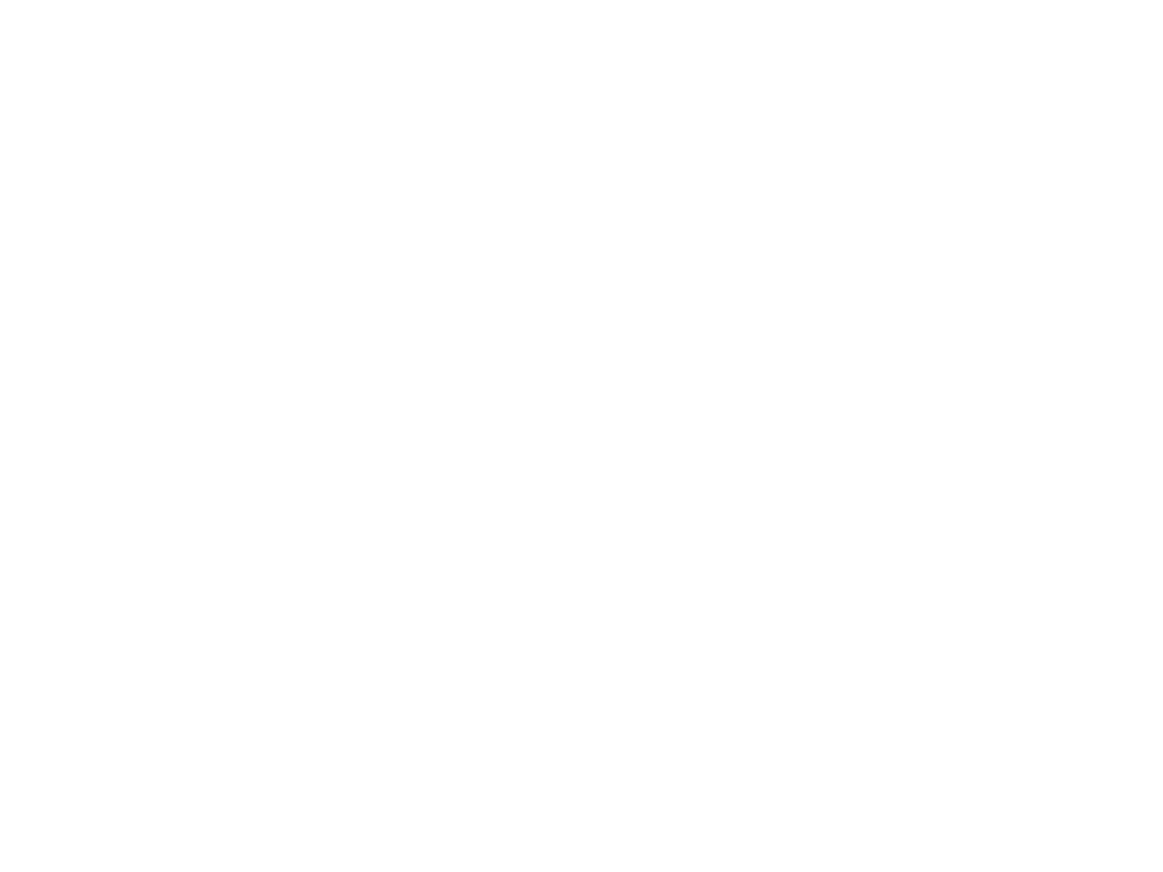

In [95]:


%matplotlib notebook

plt.figure(1)
plt.title(test_ticker+' signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(df_test_ticker.price)
plt.plot(df_test_ticker[df_test_ticker.action=="sell"].price, 'ro', label='sell')
plt.plot(df_test_ticker[df_test_ticker.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


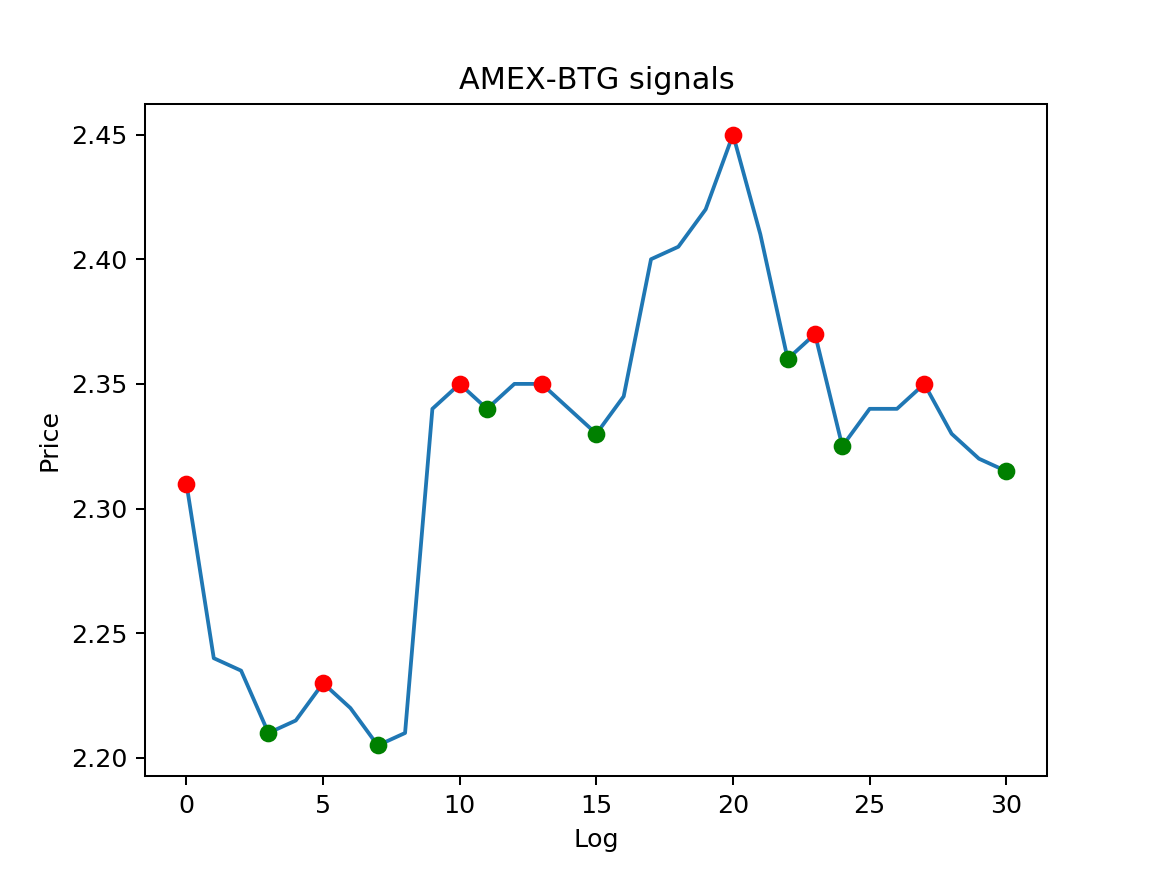

<IPython.core.display.Javascript object>


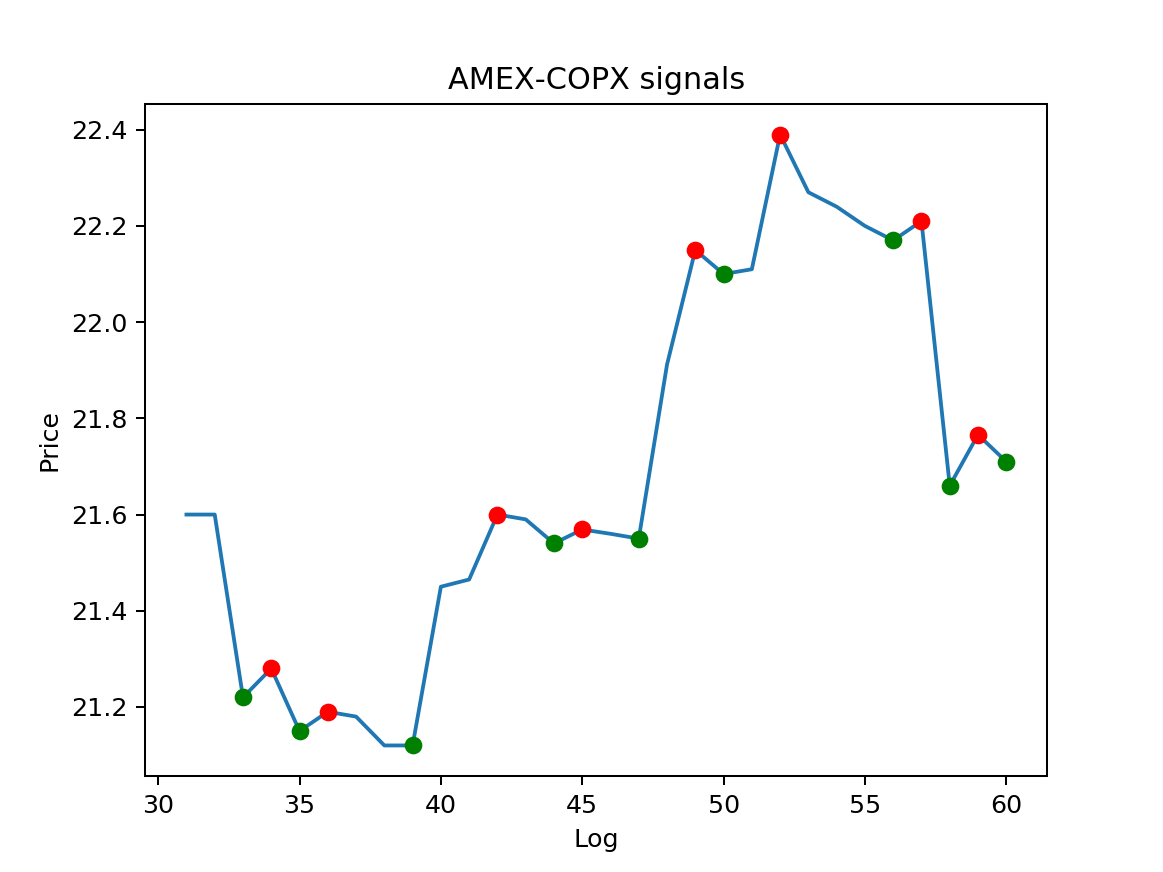

<IPython.core.display.Javascript object>


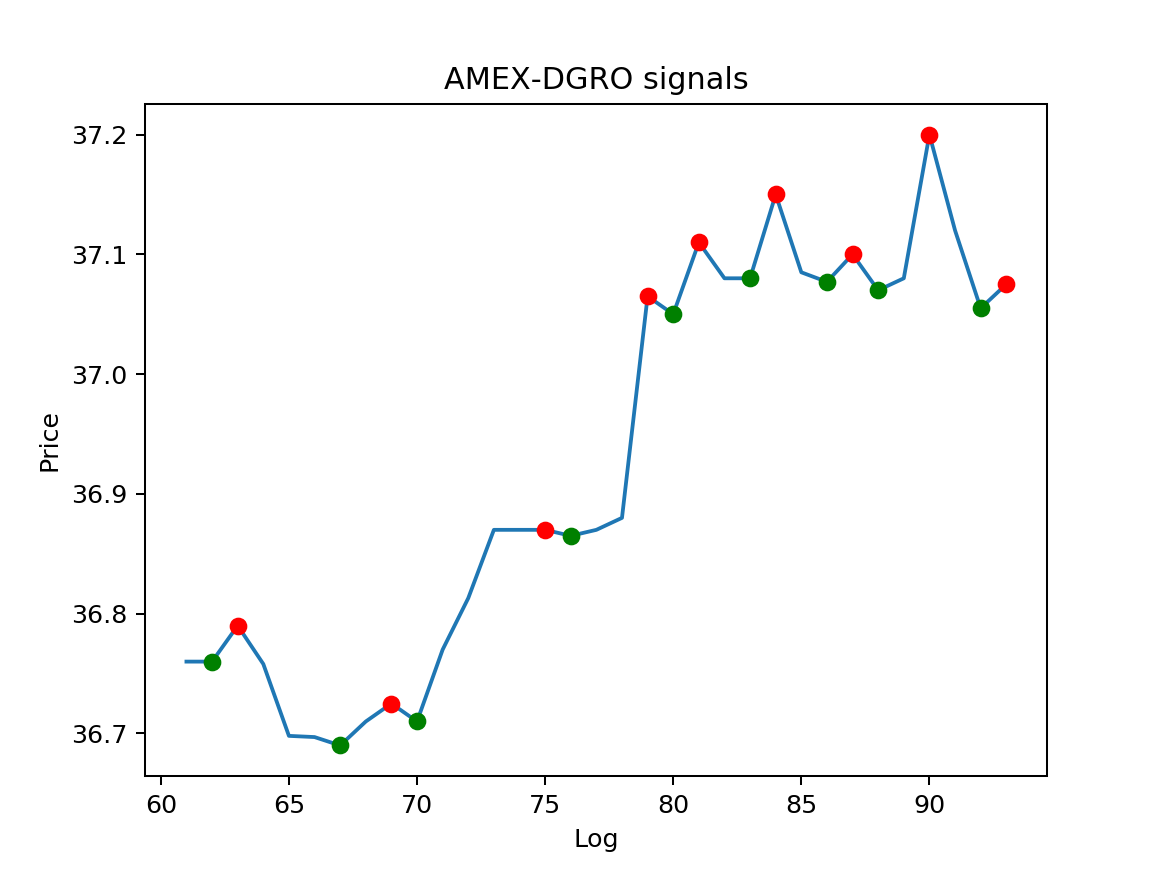

<IPython.core.display.Javascript object>


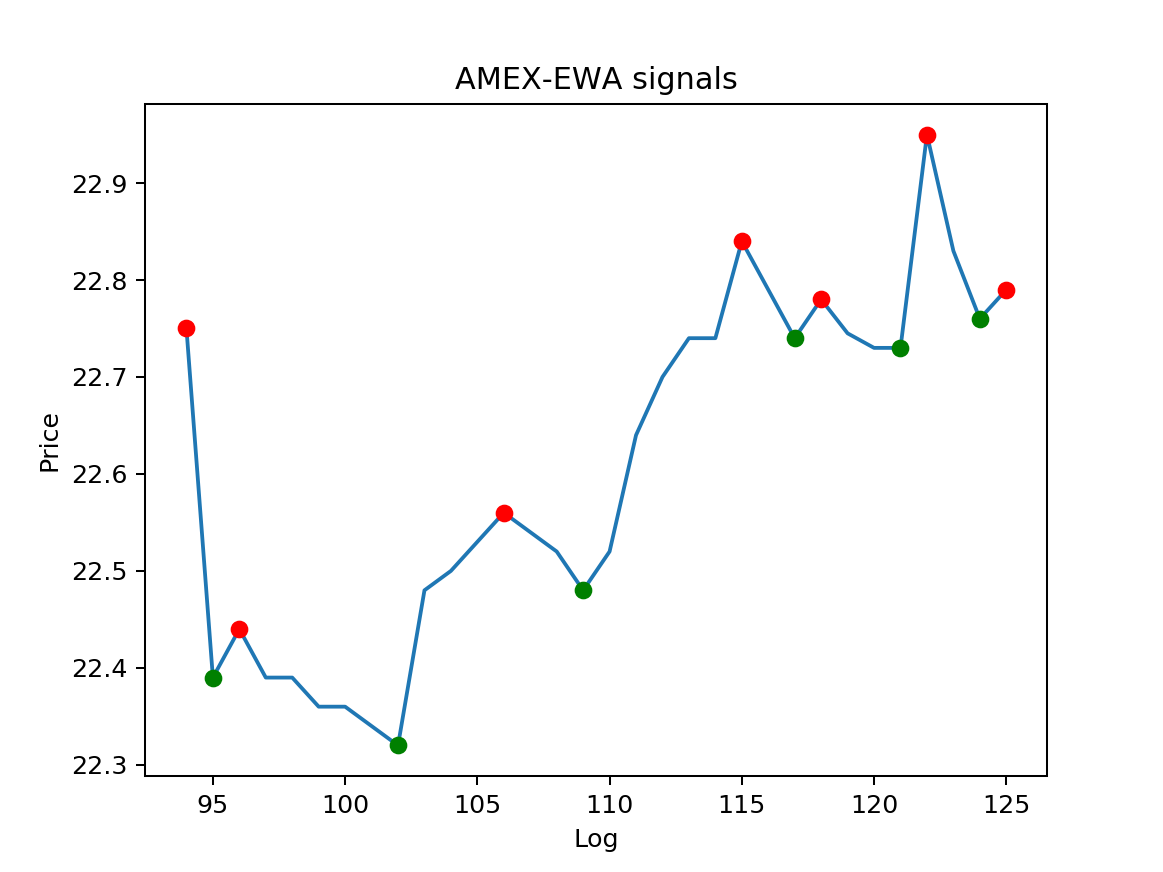

<IPython.core.display.Javascript object>


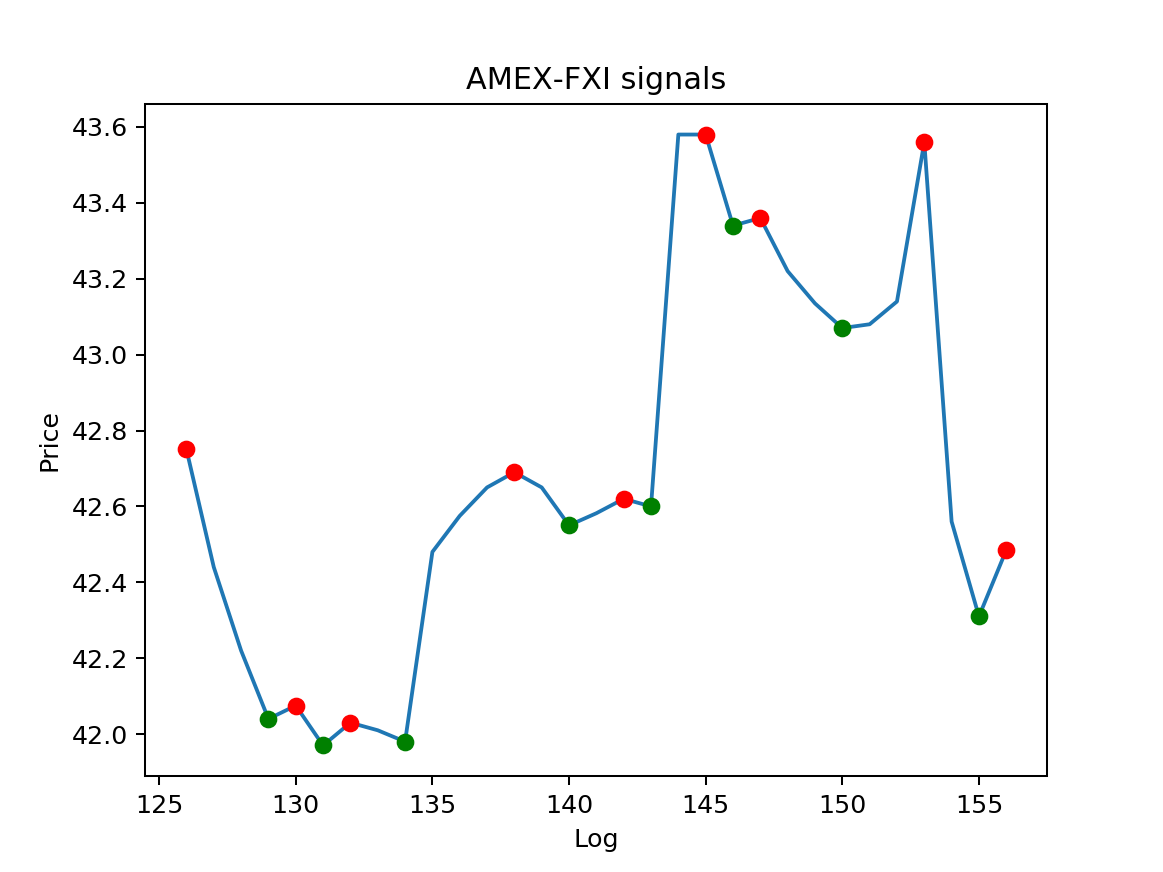

<IPython.core.display.Javascript object>


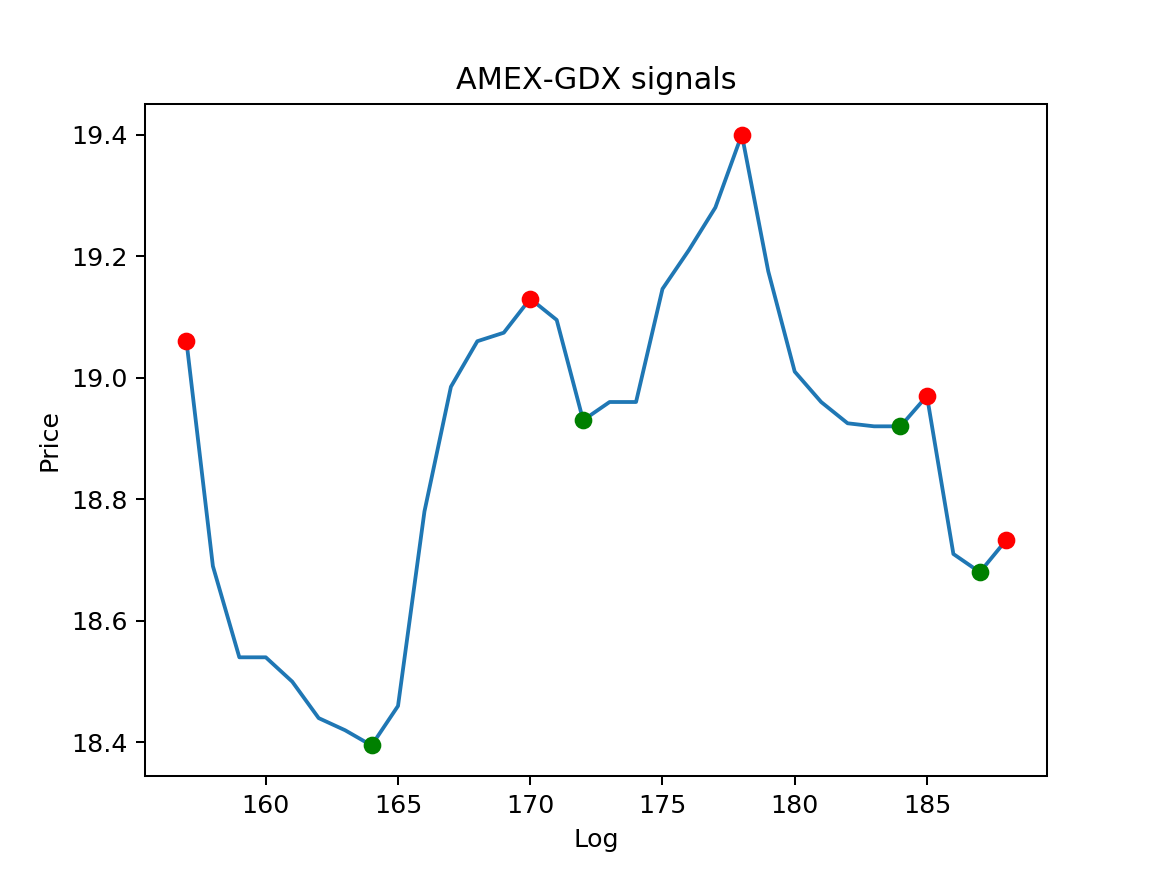

<IPython.core.display.Javascript object>


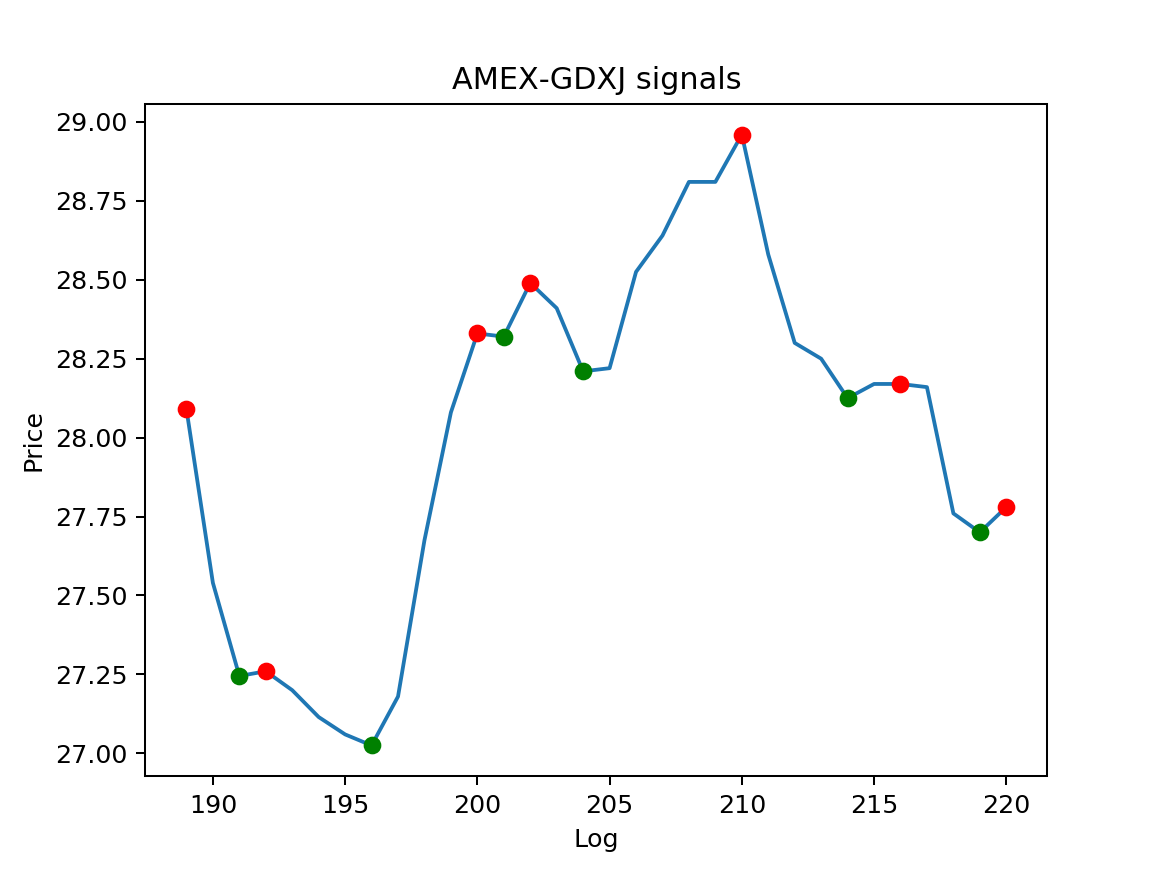

<IPython.core.display.Javascript object>


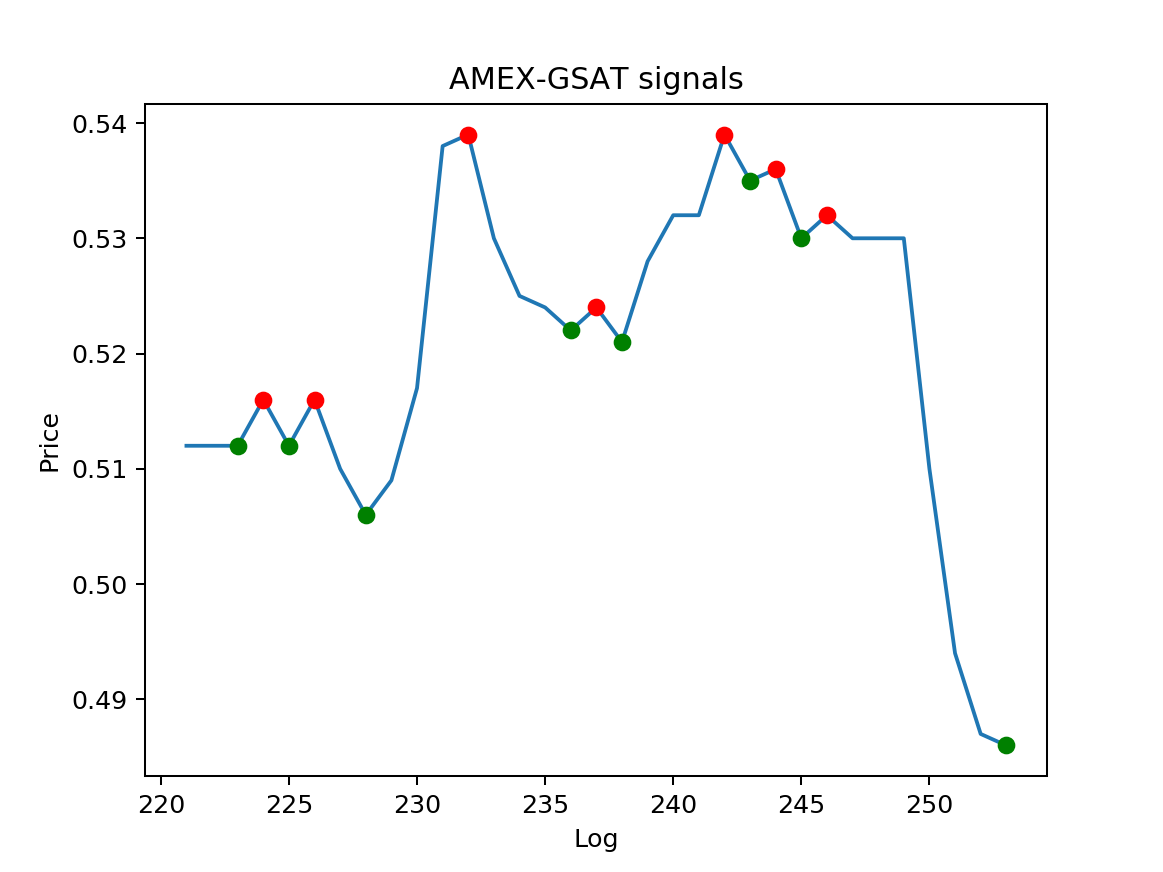

<IPython.core.display.Javascript object>


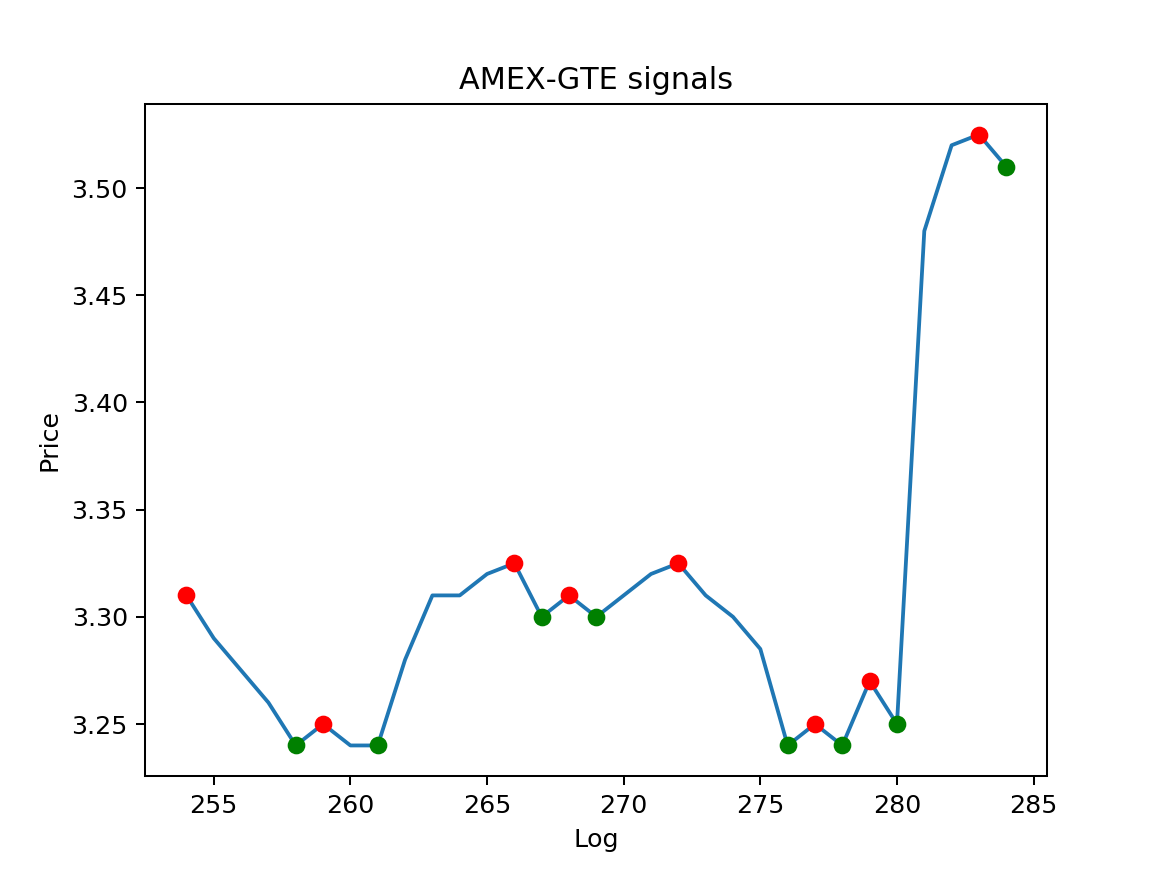

<IPython.core.display.Javascript object>


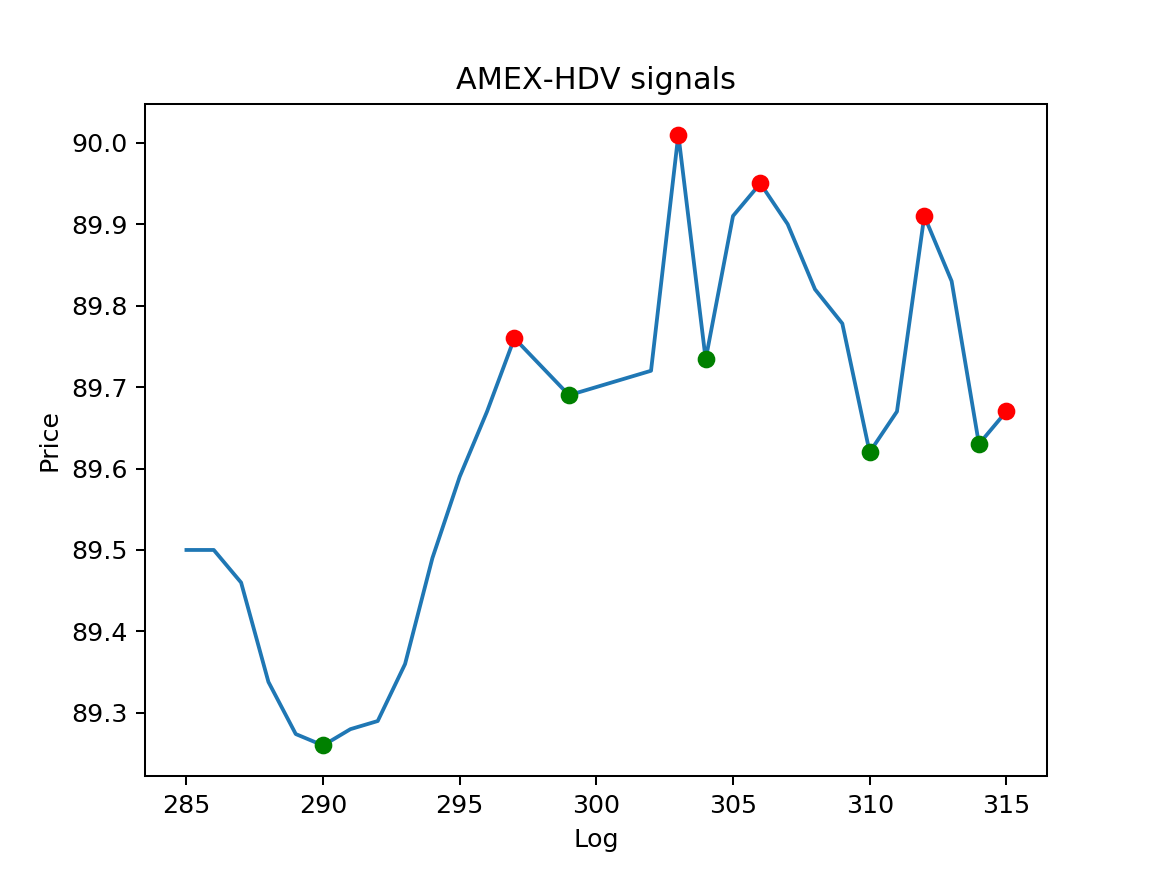

<IPython.core.display.Javascript object>


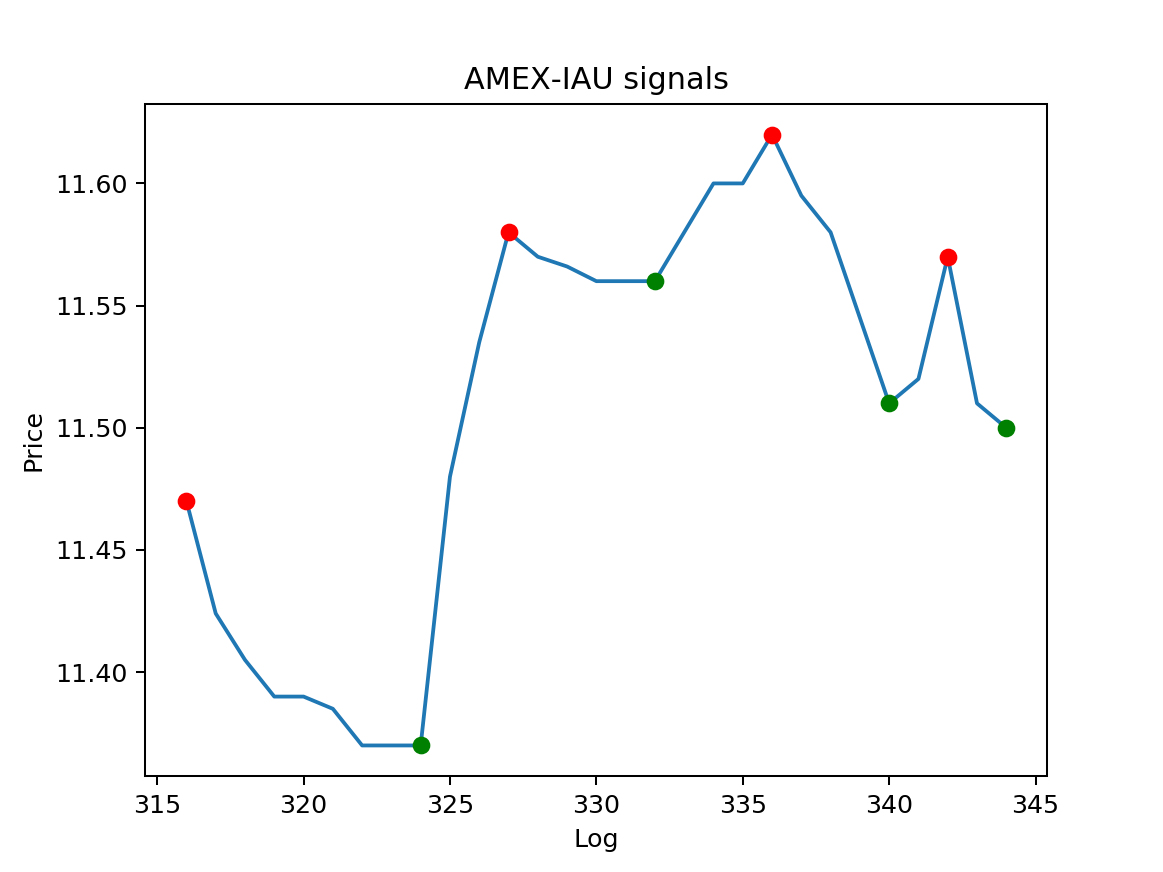

<IPython.core.display.Javascript object>


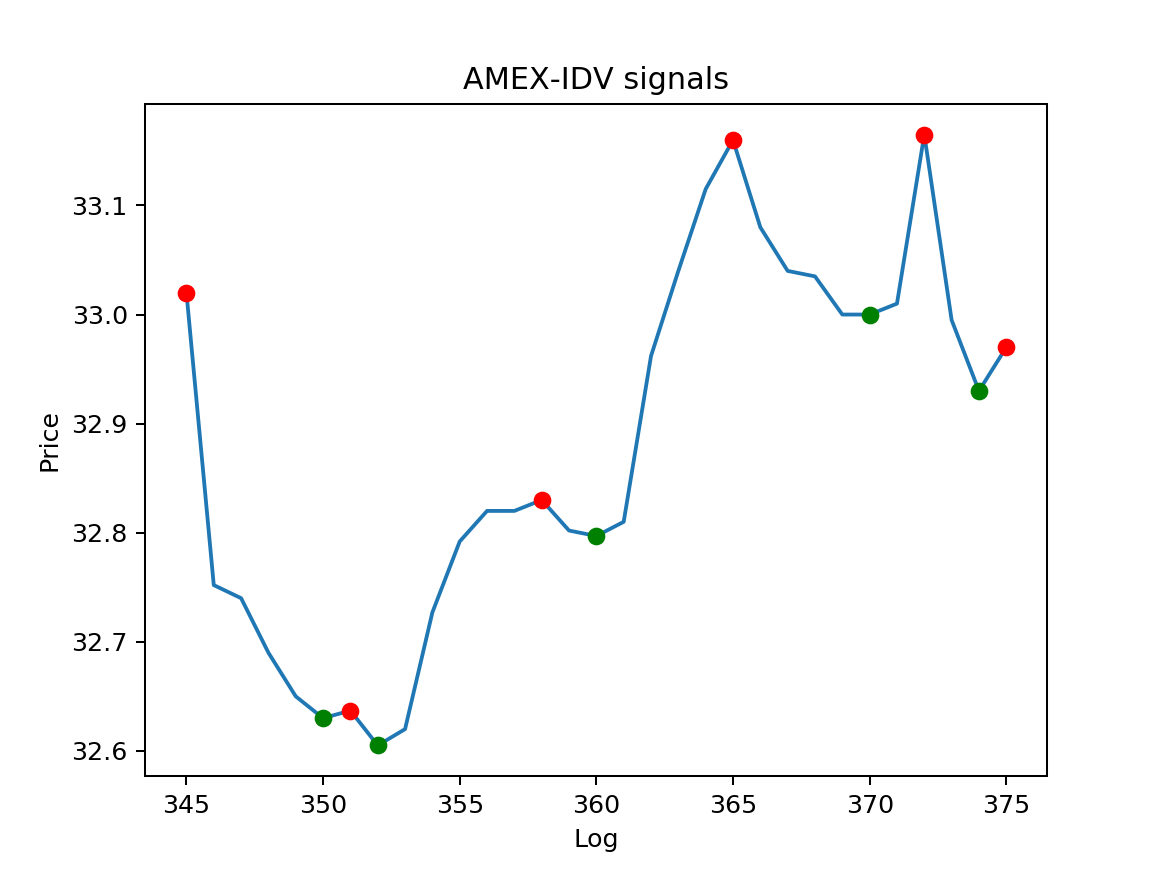

<IPython.core.display.Javascript object>


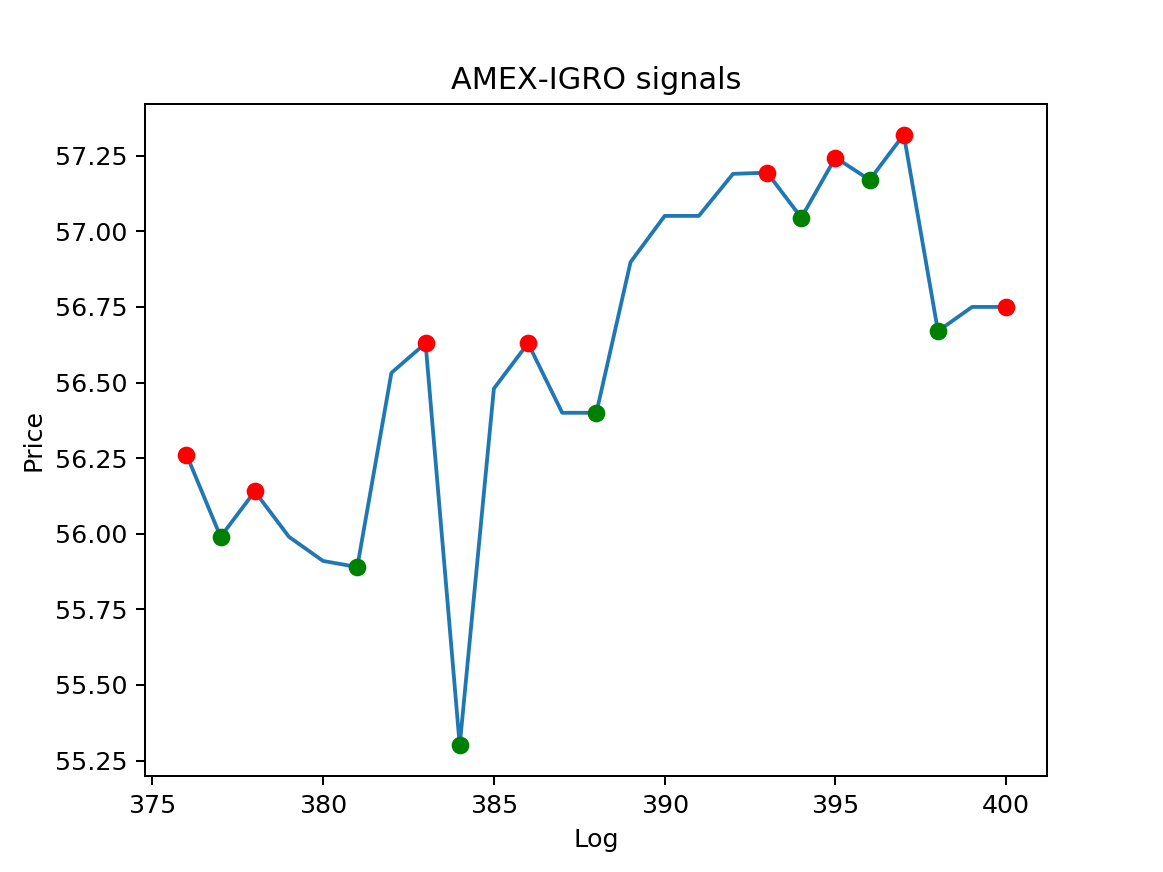

<IPython.core.display.Javascript object>


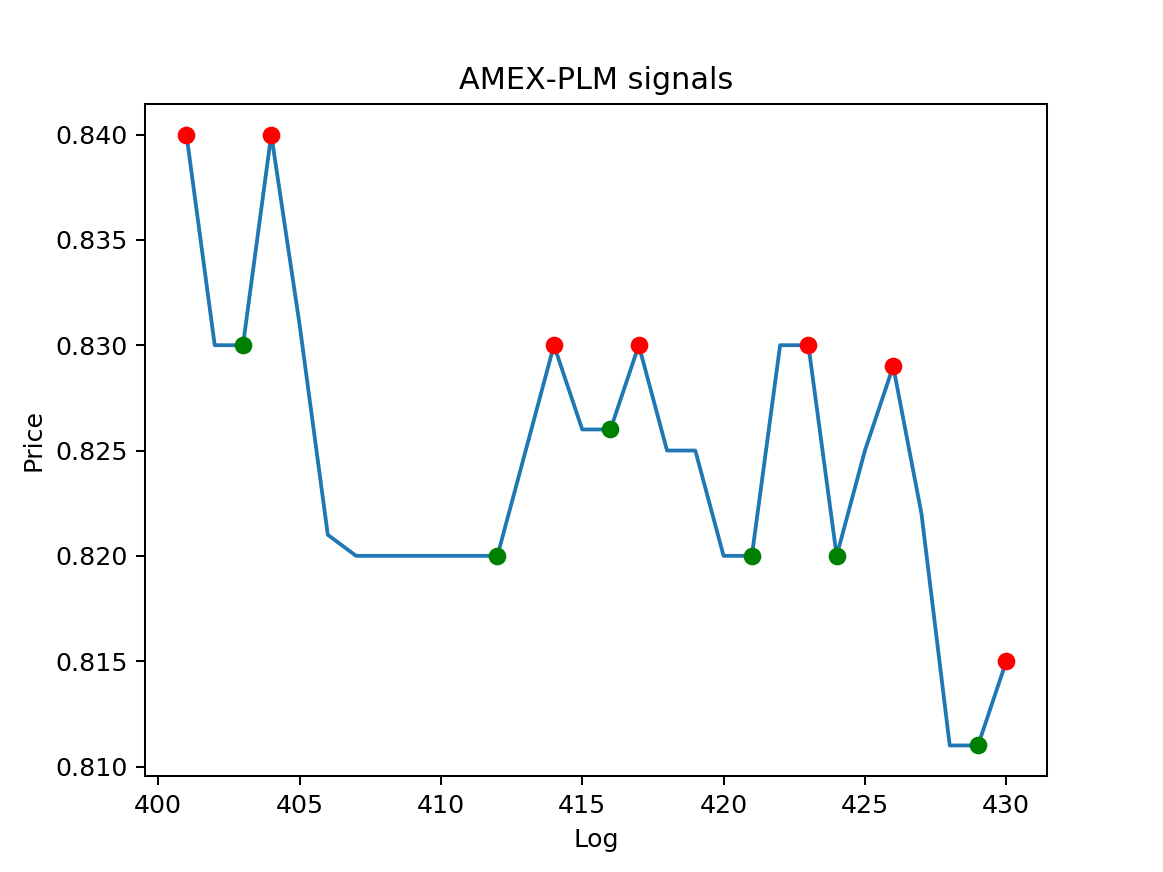

<IPython.core.display.Javascript object>


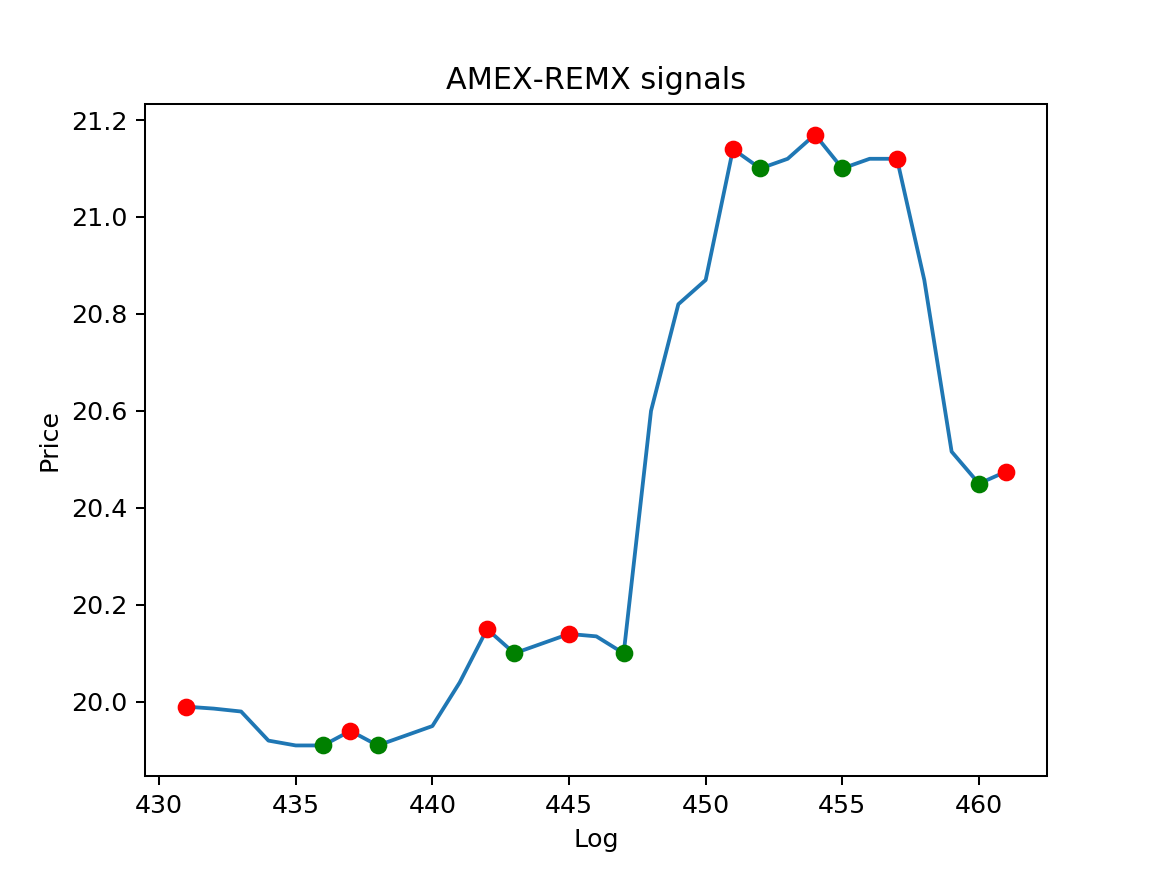

<IPython.core.display.Javascript object>


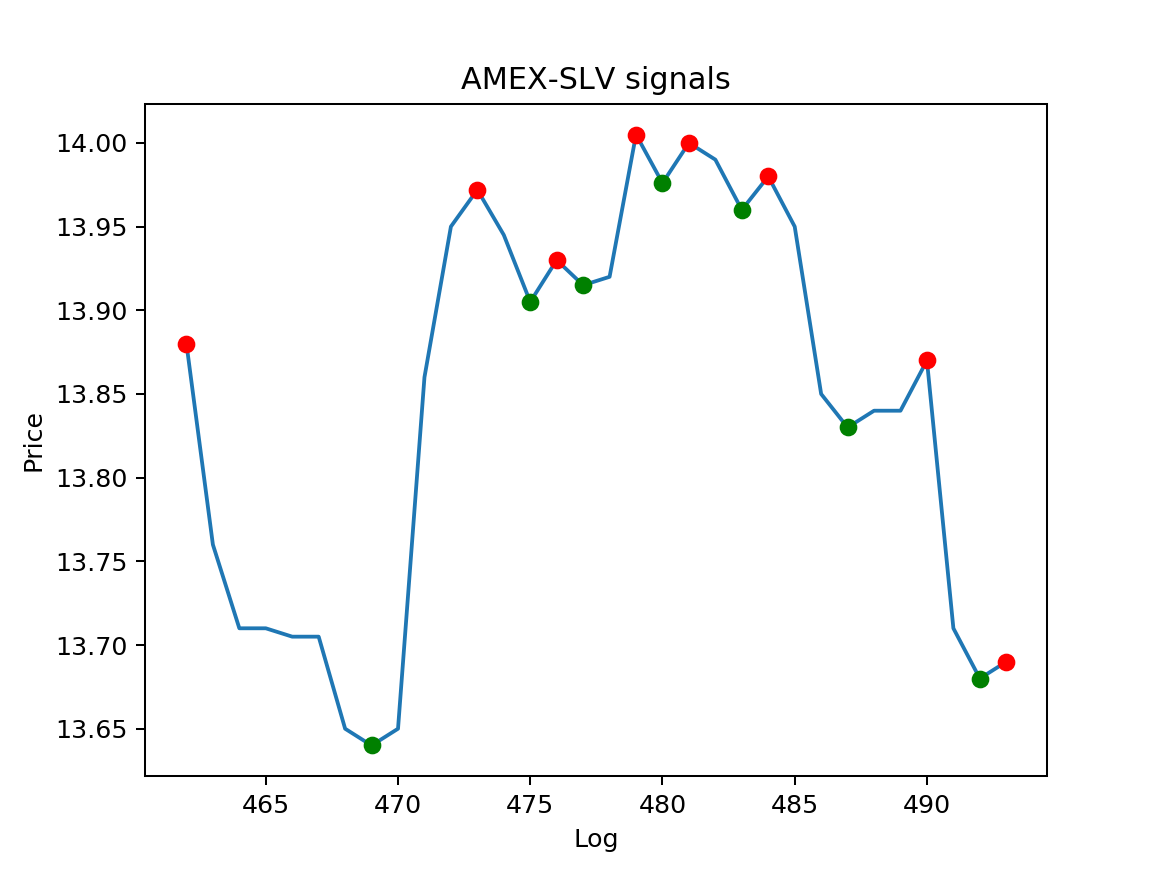

<IPython.core.display.Javascript object>


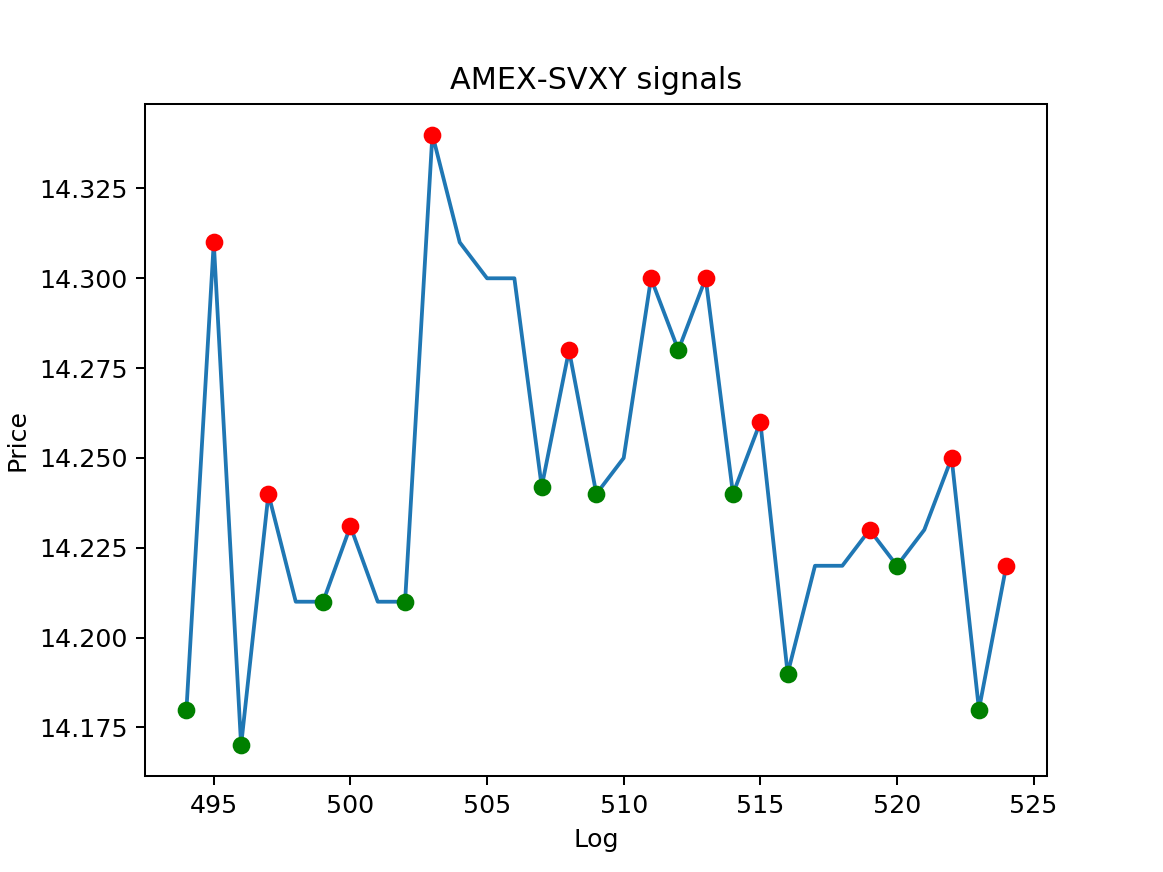

<IPython.core.display.Javascript object>


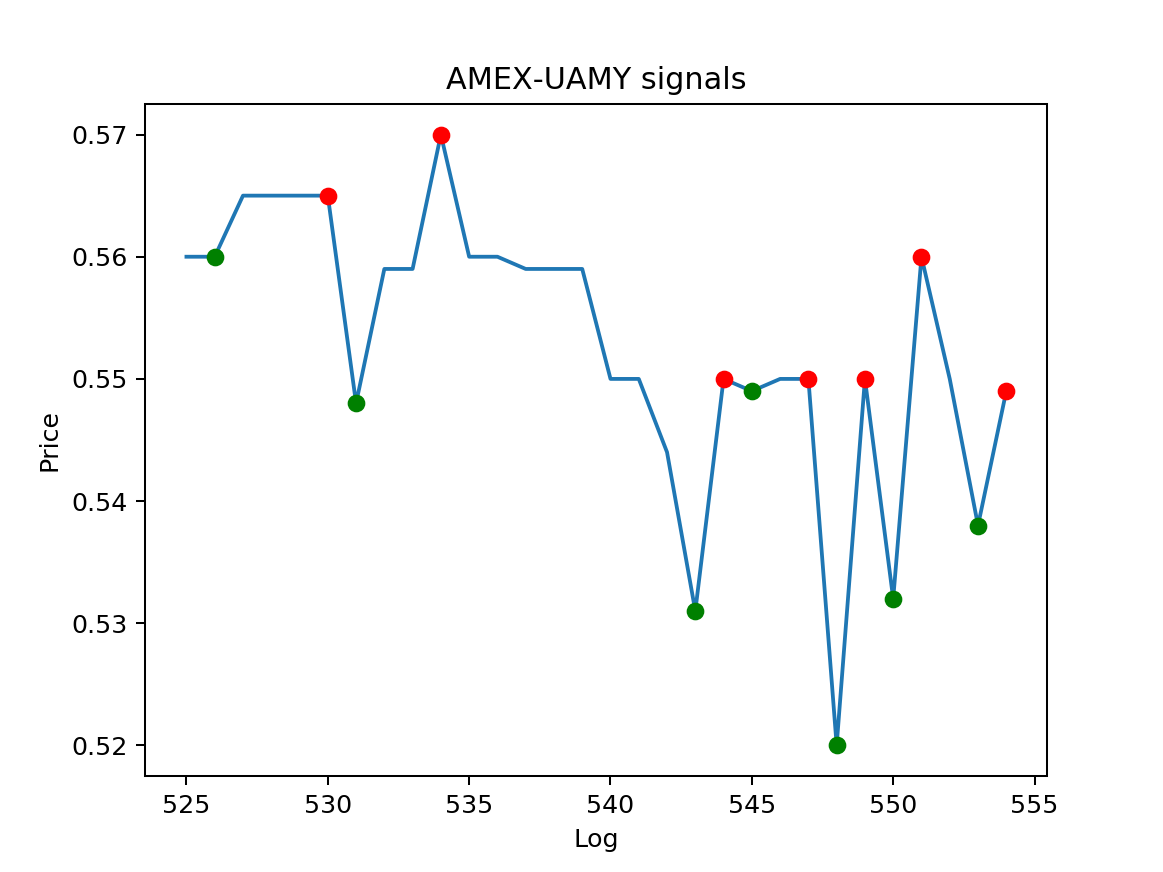

<IPython.core.display.Javascript object>


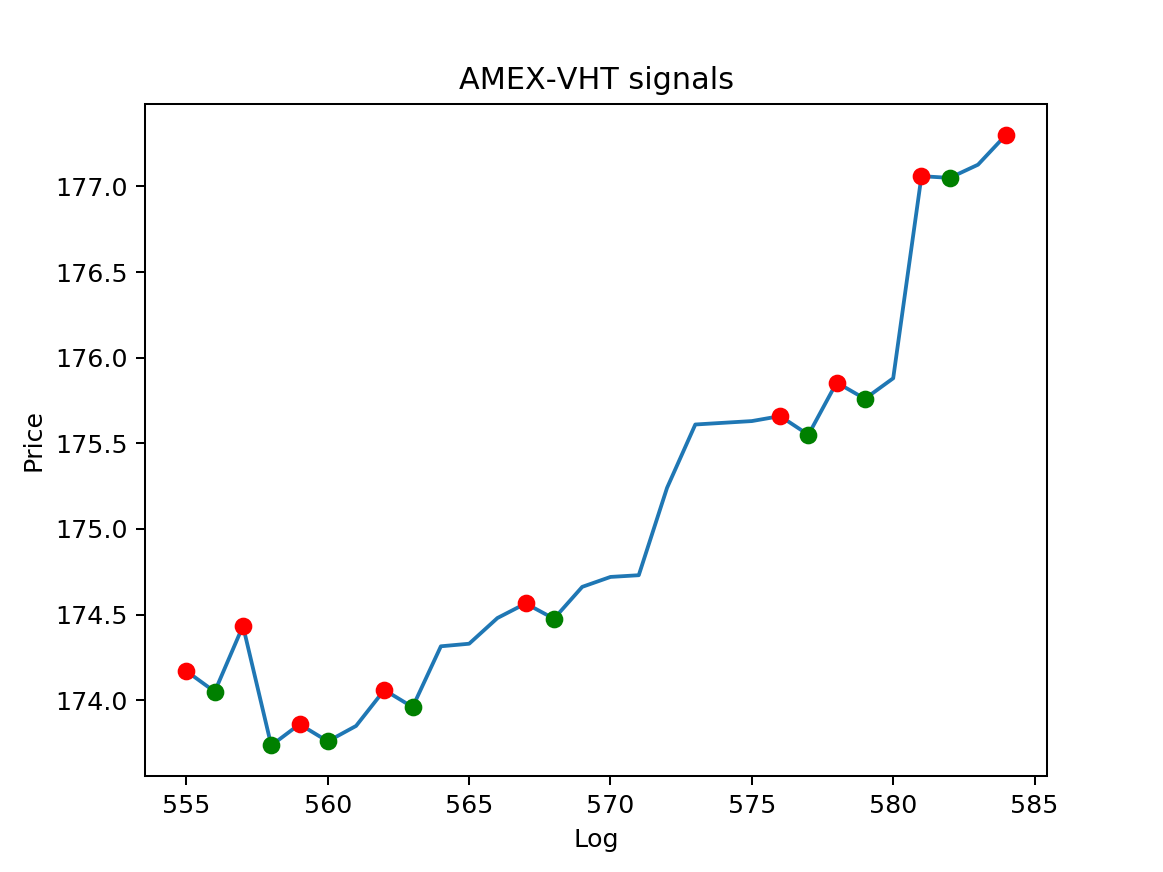

<IPython.core.display.Javascript object>


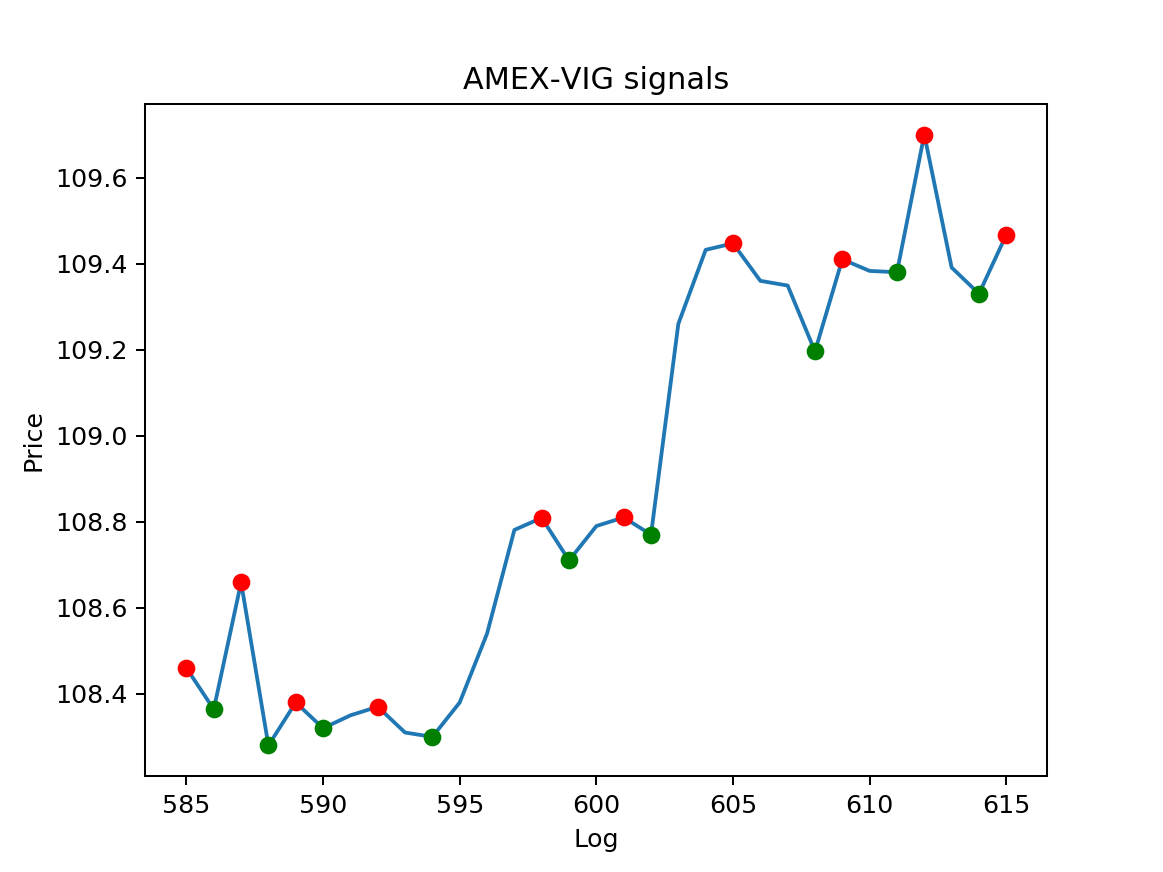

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


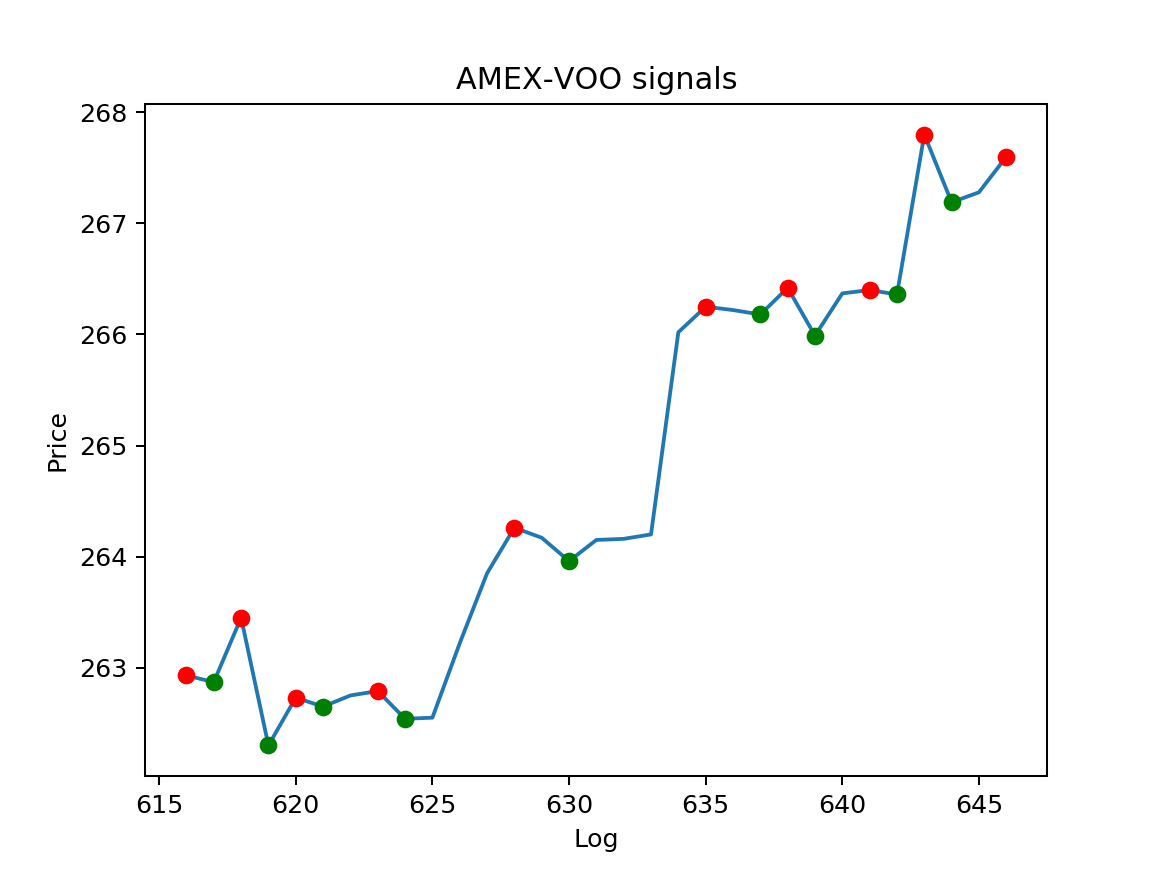

In [96]:
#visual sampling

%matplotlib notebook

unique_tickers = df_labeled.ticker.unique()
num=20
for t in unique_tickers:
    if (num>40) | (num < 20):
        continue
    num += 1

    df_test_t = df_labeled[df_labeled.ticker == t]

    plt.figure(num)
    plt.title(t+' signals')
    plt.xlabel('Log')
    plt.ylabel('Price')
    plt.plot(df_test_t.price)
    plt.plot(df_test_t[df_test_t.action=="sell"].price, 'ro', label='sell')
    plt.plot(df_test_t[df_test_t.action=="buy"].price, 'go', label='buy')
    plt.show()

In [97]:
# export truth
df_labeled.to_csv('./signals_optimal_truth_labeled.csv', header=None, index=None)